In [1]:
# import numpy as np
# import matplotlib.pyplot as plt

# # ==== 假设的能量 bins 与对应概率 ====
# bins = np.array([0,   10,   20,  30, 40,  50,    60,   70, 80])  # keV
# pdf = np.array([0.01, 0.09, 0.2, 0,  0.4, 0.1, 0.15, 0.05])  # 每个区间的相对概率

# # 归一化
# pdf = pdf / pdf.sum()

# # 计算累积分布函数（CDF）
# cdf = np.cumsum(pdf)
# bin_centers = (bins[:-1] + bins[1:]) / 2

# # ==== 画图 ====
# fig, ax = plt.subplots(2, 1, figsize=(6, 5))

# # 上图：PDF（概率密度）
# ax[0].bar(bin_centers, pdf, width=8, color='skyblue', edgecolor='k')
# ax[0].set_title('PDF: Energy Probability Distribution')
# ax[0].set_xlabel('Energy (keV)')
# ax[0].set_ylabel('Probability')

# # 下图：CDF（累积分布函数）
# ax[1].step(bin_centers, cdf, where='mid', color='orange', label='CDF')
# ax[1].set_xlabel('Energy (keV)')
# ax[1].set_ylabel('Cumulative Probability')
# ax[1].set_ylim(0, 1.05)

# # 示意几个随机数 u
# u = np.array([0.05, 0.75, 0.25, 0.55, 0.85])
# idx = np.searchsorted(cdf, u)

# # 在CDF图上画出这些随机数与对应能量区间
# for ui, i in zip(u, idx):
#     ax[1].hlines(ui, 0, bin_centers[i], color='gray', linestyle='--')
#     ax[1].vlines(bin_centers[i], 0, ui, color='gray', linestyle='--')
#     ax[1].plot(bin_centers[i], ui, 'ro')
#     ax[1].text(bin_centers[i]+1, ui+0.02, f'idx={i}', fontsize=9)

# plt.tight_layout()
# plt.show()

# print("随机数 u:", u)
# print("cdf:", cdf)
# print("对应索引 idx:", idx)
# print("对应能量 bin centers:", bin_centers[idx])


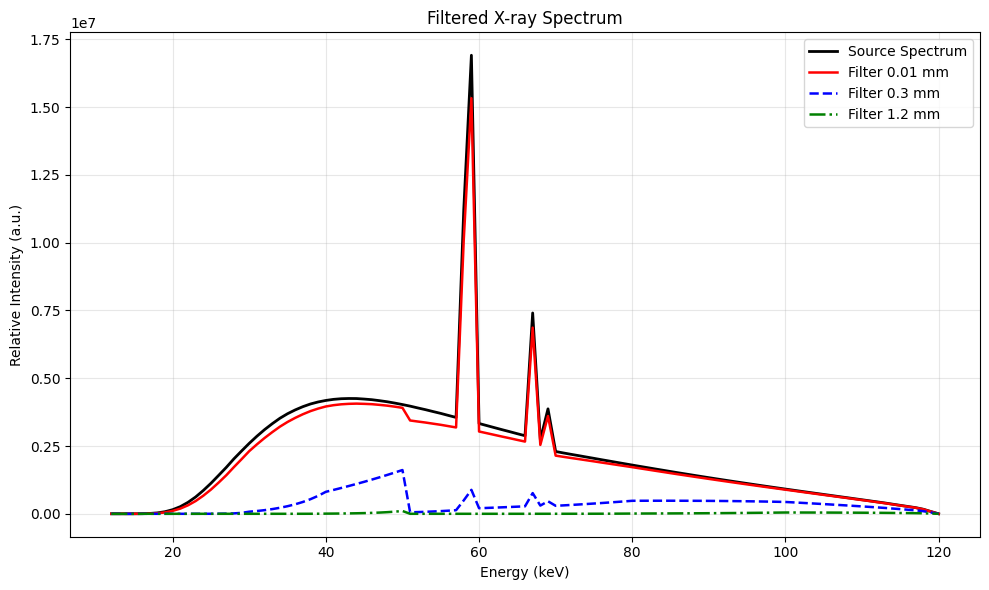

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from poisson_signal_generator_utils import generate_signal, build_energy_bins_and_pdf, compute_filtered_spectrum

## 待做：找一找 asci 本底噪声电子噪声的信号波形，来做模拟

# 参数列表：
        #   density_Ce = 6.77
        #   density_Gd = 7.90
        #   density_W  = 19.3
        #   density_Pb = 11.34
        #   density_Al = 2.70

# 1) 读取理论光谱文件,

# data = np.loadtxt('spectrum_file/spek_120.txt', 
#                   skiprows=1)     # skiprows=1，跳过第一行
# energies = data[:,0]              # 能量点，单位 keV  
# values   = data[:,1]              # 对应归一化强度 N[keV cm^2 mAs]^-1 @ 1 meter

density_Gd = 7.90
energies, Phi_in, Phi_out_list = compute_filtered_spectrum(
    spek_path="spectrum_file/spek_120.txt",
    xcom_filter_path="spectrum_file/Gd_mu_over_rho.csv",
    density= density_Gd,
    thickness_mm_list=[0.01, 0.3, 1.20],
    plot=True
)

 

In [3]:
# 1) 读取所需光谱
values = Phi_out_list[2]
bins, pdf, dE = build_energy_bins_and_pdf(energies, 
                                          values) # 构建坐标轴 计算入射计数率 λ（counts/s）# ---------- 用中心能量构造“边界” -> 保证 bins 长度 = N+1, pdf 长度 = N ----------

values_source = Phi_in


# 2) 光源物理参数
Voltage = 120                   # 管压              [kvp]
I_mA   = 120.0                  # 管电流            [mA] 
r_m    = 0.30                   # 源到探测器距离     [m]
pixel_length  = 340e-6           # 单像素尺寸340um， [m]  
pixel_length_cm = pixel_length * 100.0            # [cm]

# 2-1) 光子信号在芯片上的假设参数
pulse   = 15e-9                 # 信号脉宽 15ns      [s]
W_eV = 4.4                      # CdTe 1eV 产生一对电子 [eV/pair]
g_mat = 1000.0 / W_eV           # ~ 227 e-h pairs per keV

# 3） 芯片参数设置
delta_t = 1e-9                    # 采样帧频率 1ns     [s]
integral_time = 400e-6             # 信号积分时间 400us [s]
Capacitance = 40e-15            # 典型的 CdTe/CZT PCD 前端电容量级 [F]
gain = 1.1764/g_mat
offset  = 43.35                 # (1.1764,43.35) 来自TSPZ157B0007 pixel_0_1

# 4) 计算参数
A_cm2  = pixel_length_cm**2    # m->cm，面积用 cm^2
photon_rate = np.sum(values * dE * I_mA * (1.0/r_m)**2 * A_cm2)   # 射线源的发射率 

print("lambda*tau =", photon_rate * pulse)  # 无量纲

lambda*tau = 0.03786475491271266


In [4]:
from poisson_signal_generator_utils import make_threshold_grid_from_energy, spectrum_from_signal
from poisson_signal_generator_utils import plot_signals_over_time, plot_signals_grid

# -------- 固定全局阈值轴（重要！）-------- 

thr_grid = make_threshold_grid_from_energy(bins, gain=gain, n_thr=256)

# 5） 根据 归一化的 谱，产生时间信号
n_runs = 1   # 重复次数
integrals, differentials = [], []
signals = []  # 存每次生成的波形
 

for _ in range(n_runs):
    t, sig, times, amps = generate_signal(bins, pdf, photon_rate, 
                                      integral_time * 5, 
                                      pulse,     # 脉宽 
                                      delta_t,              # 1ns
                                      g_mat = g_mat,
                                      Cf = Capacitance,
                                      pulse_shape='gauss'
                                      )
    integ, diff = spectrum_from_signal(sig, thr_grid)
    integrals.append(integ)
    differentials.append(diff) 
    signals.append(sig)     # ✅ 保存每次的波形

integral_avg     = np.mean(integrals, axis=0)
differential_avg = np.mean(differentials, axis=0)

# ✅ 画出所有信号叠加图
# plot_signals_over_time(t, signals, max_plot=10, alpha=0.4)

# plot_signals_grid(t, signals, max_plot=4, zoom=(5.0, 5.2))

[11358.22755676 22349.01732135  9627.23204228 ... 24871.17992076
 24245.95631825 24311.70795564]


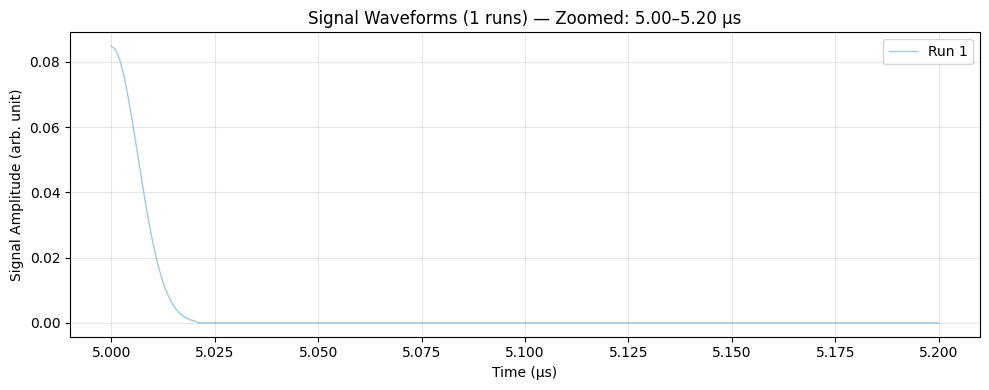

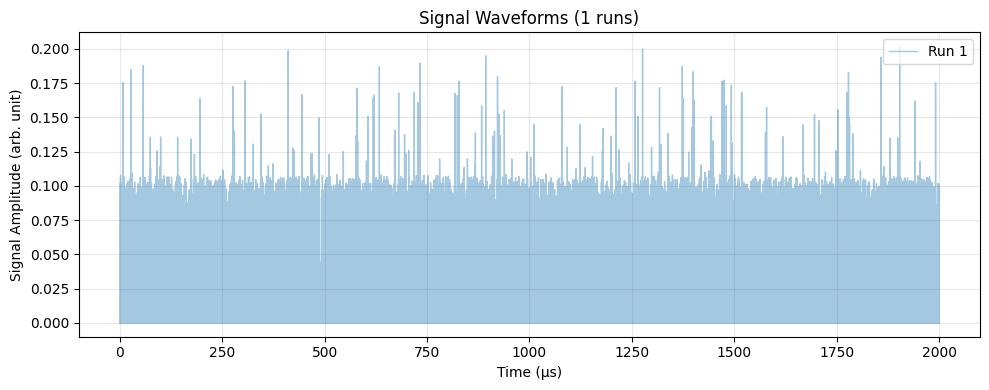

In [5]:

plot_signals_over_time(t, signals, max_plot=5, zoom=(5.0, 5.2))
plot_signals_over_time(t, signals, max_plot=5 )

In [6]:
from poisson_signal_generator_utils import report_source_max, analyze_peaks_above_threshold, quick_overlap_metrics

# 先看源最大幅度（单位与 gain 一致；gain=1 时就是 keV 等效）
report_source_max(amps, gain=1.0)

# 统计“>120”的峰：列出 top 5 个峰的时间、峰值、贡献事件数等
peaks = analyze_peaks_above_threshold(
    t, sig, times, amps,
    threshold=120.0,
    pulse_width=pulse,          # 你的脉宽
    pulse_shape='gauss',         # 或 'gauss'（若你用高斯脉冲）
    top_k=5,
    gain=1.0
)

# 看整体重叠强度
quick_overlap_metrics(times, pulse_width=pulse, rate= photon_rate)

[源最大幅度] max(amps) = 0.108  (单位 = keV等效)

[超过阈值 120.0 的峰统计] 共 0 个片段，展示 top 0：
[λτ 与重叠比例]  λτ≈0.0379， 经验 overlap_frac≈0.037


0.03686727779992029

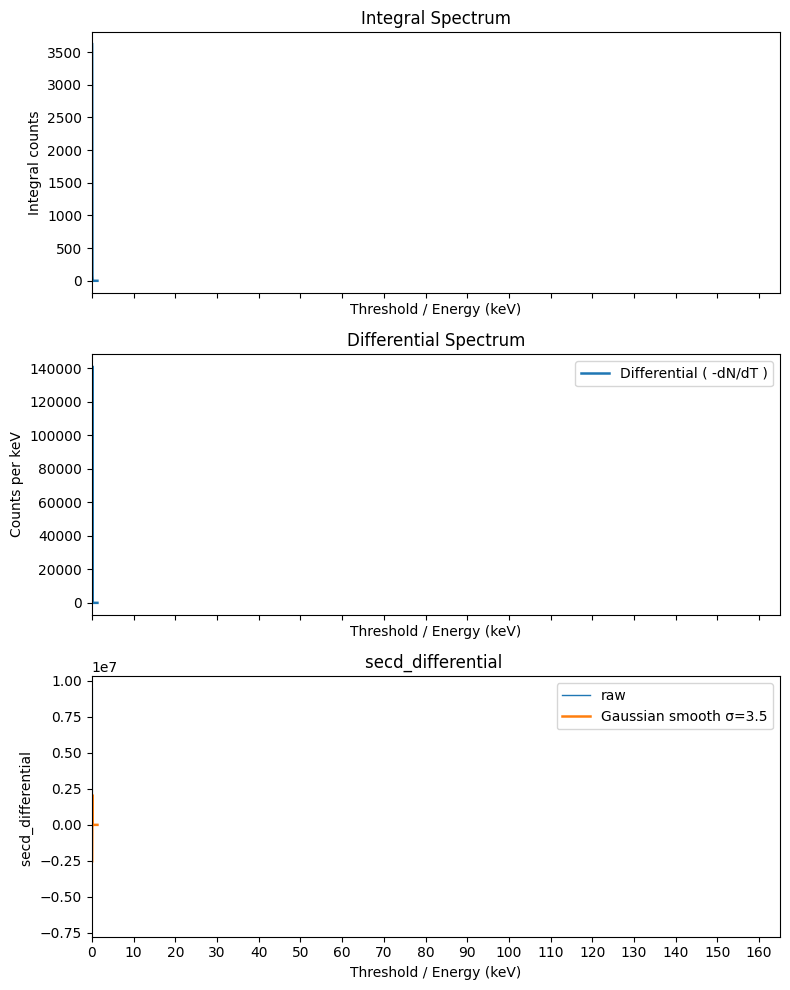

In [7]:
from scipy.ndimage import gaussian_filter1d

energy_axis = thr_grid   # keV（在你的 generate_signal 里 gain=1.0）
sigma_smooth = 3.50
secd_differential_avg = - np.gradient( differential_avg, energy_axis )
secd_differential_smooth = gaussian_filter1d(secd_differential_avg, sigma=sigma_smooth)

# --- 画图：积分谱 & 微分谱（与输入pdf作形状对比）---
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 10), sharex=True)

# 积分谱（阈值越高，计数越少）
ax1.plot(energy_axis, integral_avg, lw=1.8)
ax1.set_ylabel('Integral counts')
ax1.set_title('Integral Spectrum')
ax1.set_xlabel('Threshold / Energy (keV)')

# 微分谱（应近似输入能谱形状；仅差一个尺度因子）
ax2.plot(energy_axis, differential_avg, lw=1.8, label='Differential ( -dN/dT )')

# 可选：把输入 pdf 归一后缩放到可见范围作对比（仅形状对比）
# 这里简单按最大值对齐
orig_centers = (bins[:-1] + bins[1:]) / 2
# pdf_norm = pdf / pdf.max() * differential_avg.max() if differential_avg.max() > 0 else pdf
pdf_norm = pdf * photon_rate *3.8e-4
# ax2.plot(orig_centers, pdf_norm , '--', label='Input PDF (scaled)')

ax2.set_xlabel('Threshold / Energy (keV)')
ax2.set_ylabel('Counts per keV')
ax2.set_title('Differential Spectrum')
ax2.legend()

# 积分谱（阈值越高，计数越少）
ax3.plot(energy_axis, secd_differential_avg, lw=1.0, label='raw')
ax3.plot(energy_axis, secd_differential_smooth, lw=1.8, label=f'Gaussian smooth σ={sigma_smooth}')
ax3.set_ylabel('secd_differential ')
ax3.set_title('secd_differential ')
ax3.set_xlabel('Threshold / Energy (keV)')
ax3.legend()

for ax in (ax1, ax2, ax3):
    ax.set_xlim(0, 165)
    ax.set_xticks(np.arange(0, 166, 10))   # 每隔 5 keV 一根刻度

plt.tight_layout()
plt.show()


# 在考虑能量分辨率的情况下的结果

In [20]:
# ===== 6）在时间信号上叠加高斯噪声，模拟能量分辨率不足 =====

FWHM_keV = 10.0             # 目标能量分辨率（可以改成你想要的）
sigma_keV = FWHM_keV / 2.355
# sigma_amp = sigma_keV * gain   # gain=1 时就是 sigma_keV
 
# 对 pdf 做一维高斯卷积（频谱展宽）
pdf_blur = gaussian_filter1d(pdf, sigma=sigma_keV, mode='nearest')

# 数值误差可能导致极小的负数，截断一下
pdf_blur[pdf_blur < 0] = 0.0

# 重新归一化（保持总强度不变）
norm_factor = np.sum(pdf_blur * dE)
if norm_factor > 0:
    pdf_blur /= norm_factor


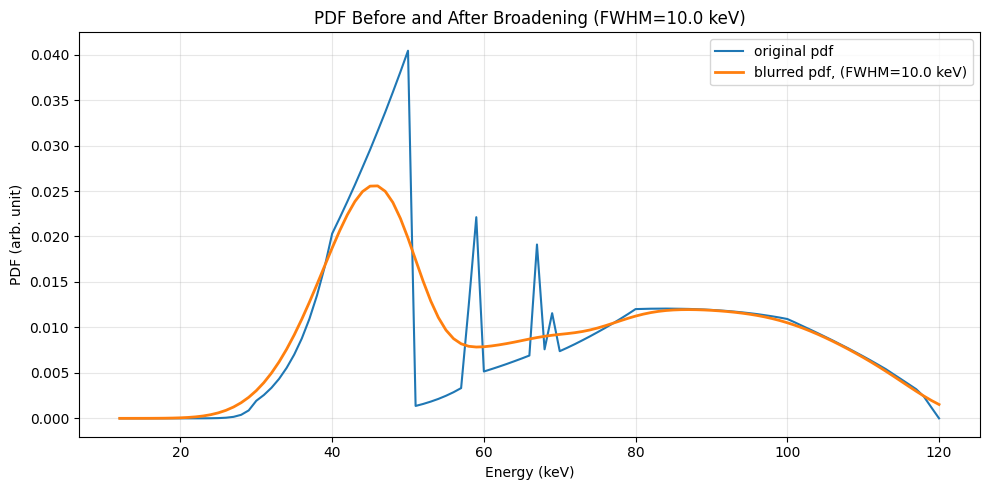

In [21]:
# ===== 画图：原谱 vs 展宽谱 =====
import matplotlib.pyplot as plt

# 横轴（能量 bin 中心）
E_centers = 0.5 * (bins[:-1] + bins[1:])
plt.figure(figsize=(10,5))
plt.plot(E_centers, pdf,       label="original pdf",   lw=1.5)
plt.plot(E_centers, pdf_blur, label=f"blurred pdf, (FWHM={FWHM_keV} keV)", lw=2.0)
plt.xlabel("Energy (keV)")
plt.ylabel("PDF (arb. unit)")
plt.title(f"PDF Before and After Broadening (FWHM={FWHM_keV} keV)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:

integrals_blur = []
differentials_blur = []
signals_blur = []  # 存每次生成的波形

for _ in range(n_runs):
    t, sig_blur, times, amps = generate_signal(bins, pdf_blur, photon_rate, 
                                      integral_time*5, 
                                      pulse,     # 脉宽 
                                      delta_t,              # 1ns
                                      gain=1.0,
                                      pulse_shape='gauss'
                                      )
    integ_blur, diff_blur = spectrum_from_signal(sig_blur, thr_grid)
    integrals_blur.append(integ_blur)
    differentials_blur.append(diff_blur) 
    signals_blur.append(sig_blur)     # ✅ 保存每次的波形

integral_avg_blur     = np.mean(integrals_blur, axis=0)
differential_avg_blur = np.mean(differentials_blur, axis=0)

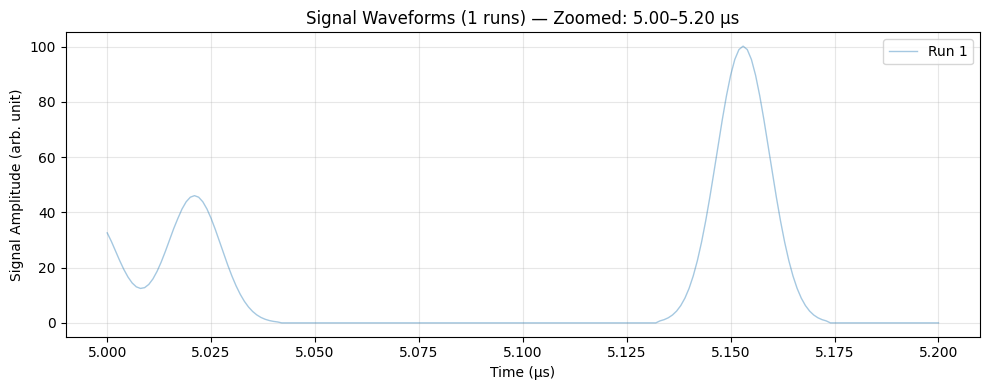

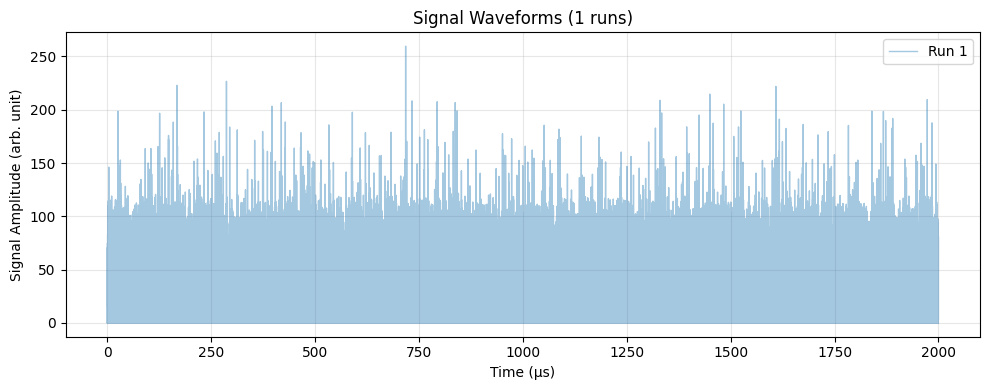

In [26]:
plot_signals_over_time(t, signals_blur, max_plot=5, zoom=(5.0, 5.2))
plot_signals_over_time(t, signals_blur, max_plot=5 )

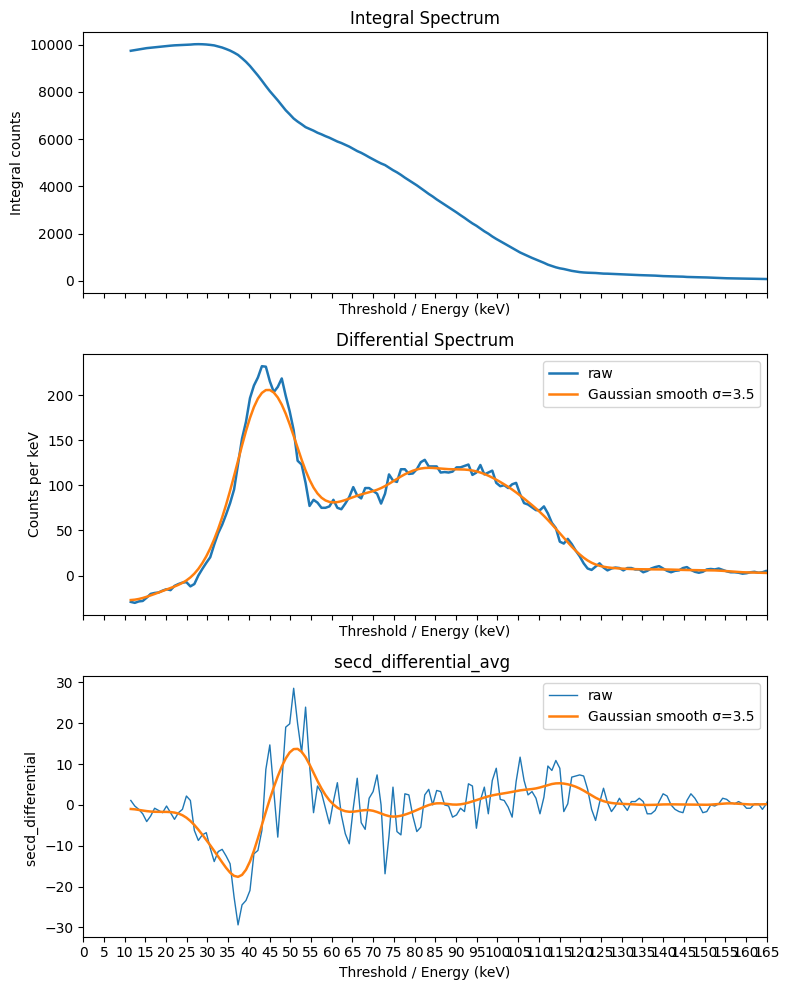

In [ ]:
from scipy.ndimage import gaussian_filter1d

energy_axis = thr_grid   # keV（在你的 generate_signal 里 gain=1.0）
sigma_smooth = 3.50

differential_smooth_blur = gaussian_filter1d(differential_avg_blur, sigma=sigma_smooth)


secd_differential_avg_blur = - np.gradient( differential_avg_blur, energy_axis )
secd_differential_smooth_blur = gaussian_filter1d(secd_differential_avg_blur, sigma=sigma_smooth)

# --- 画图：积分谱 & 微分谱（与输入pdf作形状对比）---
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 10), sharex=True)

# 积分谱（阈值越高，计数越少）
ax1.plot(energy_axis, integral_avg_blur, lw=1.8)
ax1.set_ylabel('Integral counts')
ax1.set_title('Integral Spectrum')
ax1.set_xlabel('Threshold / Energy (keV)')

# 微分谱（应近似输入能谱形状；仅差一个尺度因子）
ax2.plot(energy_axis, differential_avg_blur, lw=1.8, label='raw')
ax2.plot(energy_axis, differential_smooth_blur, lw=1.8, label=f'Gaussian smooth σ={sigma_smooth}')

# 可选：把输入 pdf 归一后缩放到可见范围作对比（仅形状对比）
# 这里简单按最大值对齐
orig_centers = (bins[:-1] + bins[1:]) / 2
# pdf_norm = pdf / pdf.max() * differential_avg.max() if differential_avg.max() > 0 else pdf
pdf_norm = pdf * photon_rate *3.8e-4
# ax2.plot(orig_centers, pdf_norm , '--', label='Input PDF (scaled)')

ax2.set_xlabel('Threshold / Energy (keV)')
ax2.set_ylabel('Counts per keV')
ax2.set_title('Differential Spectrum')
ax2.legend()

# 积分谱（阈值越高，计数越少）
ax3.plot(energy_axis, secd_differential_avg_blur, lw=1.0, label='raw')
ax3.plot(energy_axis, secd_differential_smooth_blur, lw=1.8, label=f'Gaussian smooth σ={sigma_smooth}')
ax3.set_ylabel('secd_differential ')
ax3.set_title('secd_differential_avg ')
ax3.set_xlabel('Threshold / Energy (keV)')
ax3.legend()
for ax in (ax1, ax2, ax3):
    ax.set_xlim(0, 165)
    ax.set_xticks(np.arange(0, 166, 5))   # 每隔 5 keV 一根刻度


plt.tight_layout()
plt.show()
